In [3]:
import matplotlib.pyplot as plt
from sklearn.neighbors import NearestNeighbors
from sklearn.cluster import DBSCAN
from sklearn.metrics import silhouette_score
import umap
import pickle
import numpy as np
from sklearn.metrics import adjusted_rand_score, normalized_mutual_info_score
import warnings
warnings.filterwarnings("ignore")

# 1. 加载嵌入数据
with open('data/yelp/handled/pca64_itm_emb_np.pkl', 'rb') as f:
    embeddings = pickle.load(f)

print(f"嵌入数据加载完成，形状: {embeddings.shape}")

嵌入数据加载完成，形状: (11383, 64)


In [2]:
import numpy as np

def analyze_nearest_neighbor_similarity(embeddings, k=50):
    """分析最近邻相似度分布"""
    nn = NearestNeighbors(n_neighbors=k+1, metric='cosine')  # 包含自身
    nn.fit(embeddings)
    distances, _ = nn.kneighbors(embeddings)
    
    # 计算最近邻的余弦相似度（1 - 余弦距离）
    similarities = 1 - distances[:, 1:]  # 排除自身
    
    # 计算统计量
    mean_sim = np.mean(similarities)
    median_sim = np.median(similarities)
    min_sim = np.min(similarities)
    max_sim = np.max(similarities)
    
    print(f"最近邻相似度分析 (k={k}):")
    print(f"  平均相似度: {mean_sim:.4f}")
    print(f"  中位数相似度: {median_sim:.4f}")
    print(f"  最小相似度: {min_sim:.4f}")
    print(f"  最大相似度: {max_sim:.4f}")
    
    # 绘制相似度分布直方图
    plt.figure(figsize=(10, 6))
    plt.hist(similarities.flatten(), bins=50, alpha=0.7, color='skyblue')
    plt.axvline(mean_sim, color='red', linestyle='dashed', linewidth=1, label=f'Avg: {mean_sim:.4f}')
    plt.axvline(median_sim, color='green', linestyle='dashed', linewidth=1, label=f'Mean: {median_sim:.4f}')
    plt.title('Nearest neighbor similarity Distribution')
    plt.xlabel('cos similarity')
    plt.ylabel('Frequency')
    plt.legend()
    plt.grid(alpha=0.3)
    plt.show()
    
    return similarities


最近邻相似度分析 (k=50):
  平均相似度: 0.6721
  中位数相似度: 0.6637
  最小相似度: 0.3483
  最大相似度: 1.0000


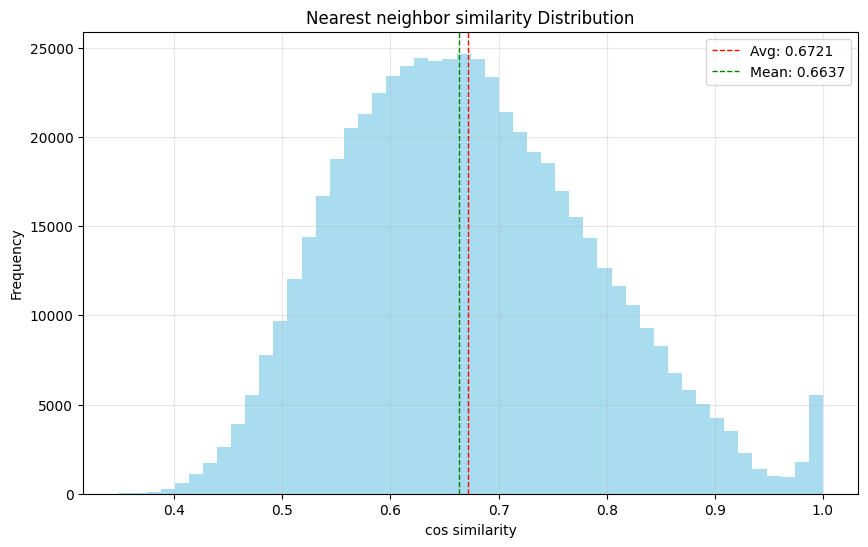

In [3]:
# 执行相似度分析
similarities = analyze_nearest_neighbor_similarity(embeddings)

In [4]:
from itertools import product
import pandas as pd

def dbscan_grid_search(embeddings, eps_list, min_samples_list):

    results = []
    
    # 遍历所有参数组合
    for eps, min_samples in product(eps_list, min_samples_list):
        # 执行DBSCAN聚类（使用余弦距离）
        dbscan = DBSCAN(eps=eps, min_samples=min_samples, metric='cosine')
        labels = dbscan.fit_predict(embeddings)
        
        # 分析聚类结果
        unique_labels, counts = np.unique(labels, return_counts=True)
        n_clusters = len(unique_labels) - (1 if -1 in unique_labels else 0)
        noise_count = counts[unique_labels == -1][0] if -1 in unique_labels else 0
        noise_ratio = noise_count / len(embeddings)
        
        # 计算轮廓系数（仅当有有效聚类时）
        sil_score = np.nan
        if n_clusters > 1:
            valid_mask = labels != -1
            if len(np.unique(labels[valid_mask])) > 1:
                try:
                    sil_score = silhouette_score(embeddings[valid_mask], 
                                               labels[valid_mask], 
                                               metric='cosine')
                except:
                    pass  # 保持为NaN如果计算失败
        
        # 记录结果
        results.append({
            'eps': eps,
            'min_samples': min_samples,
            'N': n_clusters,
            'Noise': f"{noise_count} ({noise_ratio:.2%})",
            '轮廓系数': sil_score
        })
    
    # 创建DataFrame并排序
    results_df = pd.DataFrame(results)
    
    # 按轮廓系数降序排序，然后按噪声比例升序排序
    results_df = results_df.sort_values(
        by=['轮廓系数', 'Noise'], 
        ascending=[False, True],
        na_position='last'
    )
    
    return results_df.reset_index(drop=True)


In [7]:
# 定义参数搜索范围
# eps_list = [0.25, 0.3, 0.35, 0.4, 0.45]
ep_list = [0.1, 0.2, 0.3, 0.4, 0.5]
min_samples_list = [5, 10, 20, 30, 40, 50]

results_df = dbscan_grid_search(embeddings, eps_list, min_samples_list)

In [8]:
results_df

,eps,min_samples,N,Noise,轮廓系数
0,0.25,50,15,8916 (78.33%),0.565655
1,0.25,40,25,8230 (72.30%),0.488654
2,0.25,30,27,7314 (64.25%),0.442140
3,0.30,50,19,6395 (56.18%),0.424244
4,0.30,40,21,5597 (49.17%),0.339656
5,0.25,20,38,6130 (53.85%),0.292788
6,0.30,30,22,4668 (41.01%),0.183909
7,0.25,10,53,4225 (37.12%),0.147938
8,0.35,40,6,3106 (27.29%),0.100746
9,0.30,20,25,3475 (30.53%),0.093288


In [16]:
from itertools import product
import pandas as pd
import warnings
warnings.filterwarnings("ignore")

param_grid = {
    'umap_n_neighbors': [4, 5, 6],           # 在5附近微调
    'umap_min_dist': [0.04, 0.05, 0.06],     # 在0.05附近微调
    'dbscan_eps': [0.13, 0.14, 0.15, 0.16],  # 在0.12-0.16之间细化
    'dbscan_min_samples': [10, 11, 12, 13]   # 在12附近微调
}

# # 定义参数搜索空间
# param_grid = {
#     'umap_n_neighbors': [8, 10, 12],
#     'umap_min_dist': [0.03, 0.05, 0.07],
#     'dbscan_eps': [0.12, 0.15, 0.18, 0.2],
#     'dbscan_min_samples': [4, 5, 6]
# }


results = []

for params in product(*param_grid.values()):
    # 解包参数
    n_neighbors, min_dist, eps, min_samples = params
    
    # UMAP降维
    reducer = umap.UMAP(
        n_components=8,
        n_neighbors=n_neighbors,
        min_dist=min_dist,
        metric='cosine',
        random_state=42
    )
    umap_embeds = reducer.fit_transform(embeddings)
    
    # DBSCAN聚类
    db = DBSCAN(eps=eps, min_samples=min_samples, metric='euclidean')
    labels = db.fit_predict(umap_embeds)
    
    # 计算指标
    unique_labels = set(labels)
    n_clusters = len(unique_labels) - (1 if -1 in unique_labels else 0)
    noise_ratio = np.sum(labels == -1) / len(labels)
    
    # 轮廓系数（仅当有有效聚类时）
    if n_clusters > 1:
        valid_mask = labels != -1
        if len(set(labels[valid_mask])) > 1:
            sil_score = silhouette_score(umap_embeds[valid_mask], labels[valid_mask])
        else:
            sil_score = -1
    else:
        sil_score = -1
    
    # 记录结果
    results.append({
        'n_neighbors': n_neighbors,
        'min_dist': min_dist,
        'eps': eps,
        'min_samples': min_samples,
        'n_clusters': n_clusters,
        'noise_ratio': noise_ratio,
        'silhouette': sil_score
    })

# 转换为DataFrame并排序
results_df = pd.DataFrame(results)
results_df = results_df.sort_values(by=['silhouette', 'n_clusters'], ascending=[False, False])
# results_df.to_csv('clustering_optimization_results.csv', index=False)

In [17]:
results_df

,n_neighbors,min_dist,eps,min_samples,n_clusters,noise_ratio,silhouette
35,4,0.06,0.13,13,250,0.516121,0.794967
83,5,0.06,0.13,13,238,0.457964,0.791974
19,4,0.05,0.13,13,258,0.490644,0.790982
3,4,0.04,0.13,13,262,0.474743,0.790624
18,4,0.05,0.13,12,288,0.451199,0.784576
...,...,...,...,...,...,...,...
60,5,0.04,0.16,10,311,0.201792,0.645937
124,6,0.05,0.16,10,288,0.189669,0.643806
104,6,0.04,0.15,10,301,0.201529,0.640029
140,6,0.06,0.16,10,303,0.204076,0.637175


In [18]:
results_df.head(25)

,n_neighbors,min_dist,eps,min_samples,n_clusters,noise_ratio,silhouette
35,4,0.06,0.13,13,250,0.516121,0.794967
83,5,0.06,0.13,13,238,0.457964,0.791974
19,4,0.05,0.13,13,258,0.490644,0.790982
3,4,0.04,0.13,13,262,0.474743,0.790624
18,4,0.05,0.13,12,288,0.451199,0.784576
67,5,0.05,0.13,13,243,0.435035,0.784233
34,4,0.06,0.13,12,284,0.467364,0.782901
2,4,0.04,0.13,12,302,0.422736,0.778967
23,4,0.05,0.14,13,266,0.455240,0.777767
17,4,0.05,0.13,11,334,0.391285,0.777232
